In [35]:
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import xgboost as xgb

In [2]:
from IPython.display import display
import graphviz 
from sklearn.tree import export_graphviz
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
import time

In [4]:
#for i in range(10):
#    display(i)

# Extracting the data

In [4]:
!curl https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv >CreditScoring.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  178k  100  178k    0     0   671k      0 --:--:-- --:--:-- --:--:--  688k


In [5]:
!head CreditScoring.csv

"Status","Seniority","Home","Time","Age","Marital","Records","Job","Expenses","Income","Assets","Debt","Amount","Price"
1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
1,0,1,36,26,1,1,1,46,107,0,0,310,910
1,1,2,60,36,2,1,1,75,214,3500,0,650,1645
1,29,2,60,44,2,1,1,75,125,10000,0,1600,1800
1,9,5,12,27,1,1,1,35,80,0,0,200,1093
1,0,2,60,32,2,1,3,90,107,15000,0,1200,1957


# Loading and transforming the data

In [6]:
df = pd.read_csv("CreditScoring.csv")

In [7]:
df.shape

(4455, 14)

In [7]:
df.columns

Index(['Status', 'Seniority', 'Home', 'Time', 'Age', 'Marital', 'Records',
       'Job', 'Expenses', 'Income', 'Assets', 'Debt', 'Amount', 'Price'],
      dtype='object')

In [8]:
# Lower case column names
df.columns = df.columns.str.lower()

In [9]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [10]:
df.dtypes

status       int64
seniority    int64
home         int64
time         int64
age          int64
marital      int64
records      int64
job          int64
expenses     int64
income       int64
assets       int64
debt         int64
amount       int64
price        int64
dtype: object

Categorical variables have been label encoded in the dataset, which we want to undo

In [11]:
categorical_variables = ['status', 'home', 'marital', 'records','job']
for c in categorical_variables:
    print(df[c].value_counts())
    print("****")


status
1    3200
2    1254
0       1
Name: count, dtype: int64
****
home
2    2107
1     973
5     783
6     319
3     247
4      20
0       6
Name: count, dtype: int64
****
marital
2    3241
1     978
4     130
3      67
5      38
0       1
Name: count, dtype: int64
****
records
1    3682
2     773
Name: count, dtype: int64
****
job
1    2806
3    1024
2     452
4     171
0       2
Name: count, dtype: int64
****


In [12]:
variable_values = {}
variable_values["status"] = {0:"unknown", 1:"good", 2:"bad"}
variable_values["home"] = {0:"unknown", 1:"rent", 2:"owner", 3:"priv", 4:"ignore", 5:"parents", 6:"other"}
variable_values["marital"] = {0:"unknown", 1:"single", 2:"married", 3:"widow", 4:"separated", 5:"divorced"}
variable_values["records"] = {0:"unknown", 1:"no", 2:"yes"}
variable_values["job"] = {0:"unknown", 1:"fixed", 2:"part_time", 3:"freelance", 4:"others"}



In [13]:
for c in variable_values:
    df[c] = df[c].map(variable_values[c])

In [14]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,good,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,good,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,bad,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,good,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,good,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [15]:
df.dtypes

status       object
seniority     int64
home         object
time          int64
age           int64
marital      object
records      object
job          object
expenses      int64
income        int64
assets        int64
debt          int64
amount        int64
price         int64
dtype: object

In [16]:
set(df.dtypes[df.dtypes == object].index) == set(categorical_variables)

True

In [17]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


missing values (coded as 99999999) !!

In [18]:
for c in df.columns:
    if c not in categorical_variables:
        df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [19]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [20]:
for c in categorical_variables:
    df = df[df[c]!= "unknown"]

In [21]:
df = df.reset_index(drop=True)

In [22]:
df

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,good,9,rent,60,30,married,no,freelance,73,129.0,0.0,0.0,800,846
1,good,17,rent,60,58,widow,no,fixed,48,131.0,0.0,0.0,1000,1658
2,bad,10,owner,36,46,married,yes,freelance,90,200.0,3000.0,0.0,2000,2985
3,good,0,rent,60,24,single,no,fixed,63,182.0,2500.0,0.0,900,1325
4,good,0,rent,36,26,single,no,fixed,46,107.0,0.0,0.0,310,910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4441,bad,1,rent,60,39,married,no,fixed,69,92.0,0.0,0.0,900,1020
4442,good,22,owner,60,46,married,no,fixed,60,75.0,3000.0,600.0,950,1263
4443,bad,0,owner,24,37,married,no,part_time,60,90.0,3500.0,0.0,500,963
4444,good,0,rent,48,23,single,no,freelance,49,140.0,0.0,0.0,550,550


## Split into train, val and test datasets

In [23]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1) # 0.25*0.8 = 0.2 = val size, so 60-20-20 split

In [24]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [25]:
df_train.shape, df_val.shape, df_test.shape

((2667, 14), (889, 14), (890, 14))

In [26]:
y_train = (df_train["status"] == "bad").astype(int).values
y_val = (df_val["status"] == "bad").astype(int).values
y_test = (df_test["status"] == "bad").astype(int).values

In [28]:
y_train.shape, y_val.shape, y_test.shape

((2667,), (889,), (890,))

In [27]:
del df_train["status"]
del df_val["status"]
del df_test["status"]

# Construct feature matrix

In [28]:
train_dict = df_train.fillna(0).to_dict(orient='records') #turn each row into a dictionary

In [29]:
train_dict[0] #first row

{'seniority': 4,
 'home': 'owner',
 'time': 60,
 'age': 26,
 'marital': 'married',
 'records': 'no',
 'job': 'fixed',
 'expenses': 45,
 'income': 152.0,
 'assets': 4000.0,
 'debt': 1200.0,
 'amount': 950,
 'price': 1050}

In [30]:
v = DictVectorizer(sparse=False)

In [31]:
X_train = v.fit_transform(train_dict) # does one hot encoding of the categorical variables in the process

In [32]:
X_train.shape

(2667, 26)

In [33]:
df_train.shape

(2667, 13)

In [34]:
v.get_feature_names_out()

array(['age', 'amount', 'assets', 'debt', 'expenses', 'home=ignore',
       'home=other', 'home=owner', 'home=parents', 'home=priv',
       'home=rent', 'income', 'job=fixed', 'job=freelance', 'job=others',
       'job=part_time', 'marital=divorced', 'marital=married',
       'marital=separated', 'marital=single', 'marital=widow', 'price',
       'records=no', 'records=yes', 'seniority', 'time'], dtype=object)

# Validation

In [37]:
val_dict = df_val.fillna(0).to_dict(orient='records') #turn each row into a dictionary
X_val = v.transform(val_dict)

# XGBoost

In [38]:
features = v.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_val, y_val)

In [39]:
xgb_params = {
    'eta':0.3,
    'max_depth': 6,
    'min_child_weight': 1, #min samples leaf
    'objective': 'binary:logistic',
    'nthreads':4, # num threads
    'seed': 1,
    'verbosity': 1, # 1 = show only warnings
    
}
model = xgb.train(xgb_params, dtrain, num_boost_round=200)

/Users/ideallaedi/.local/share/virtualenvs/mlzoomcamp-2023-F6NG9Yfl/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:36:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "nthreads" } are not used.

  warnings.warn(smsg, UserWarning)


In [40]:
y_val_pred = model.predict(dval)

In [41]:
y_val_pred

array([2.78430227e-02, 8.78737390e-01, 9.95748103e-01, 1.09068379e-02,
       9.26460385e-01, 2.91341916e-02, 1.20035984e-01, 8.15911591e-01,
       8.48637283e-01, 8.03067923e-01, 3.58438760e-01, 3.52680311e-02,
       9.61311981e-02, 8.47409964e-01, 5.63366222e-04, 5.32043800e-02,
       1.81001826e-06, 2.66729272e-04, 1.35694938e-02, 1.83784649e-01,
       9.01744142e-03, 3.38642299e-01, 2.00141985e-02, 1.27251223e-02,
       9.65066373e-01, 1.83605868e-02, 9.90752935e-01, 1.97732121e-01,
       7.21927106e-01, 3.68983746e-01, 7.54784822e-01, 2.90591538e-06,
       9.47456658e-01, 3.26905608e-01, 3.77072334e-01, 1.57626346e-02,
       2.83978134e-02, 9.97479379e-01, 3.07272351e-03, 9.63905215e-01,
       9.99819100e-01, 6.18396327e-03, 4.69275117e-01, 6.87606931e-01,
       3.48805822e-02, 9.97541189e-01, 2.74076039e-04, 9.39958930e-01,
       9.96195197e-01, 7.56407306e-02, 2.07182810e-01, 9.26467404e-02,
       7.14834430e-04, 1.34295058e-02, 9.99481976e-01, 2.36467604e-05,
      

In [45]:
roc_auc_score(y_train, model.predict(dtrain)) # prone to overfitting

1.0

In [42]:
roc_auc_score(y_val, y_val_pred)

0.8078653640589654

In [47]:
roc_auc_score(y_train, better_tree.predict_proba(X_train)[:,1])

0.7660357518401681

# Train while tracking val metrics

In [48]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [51]:
xgb_params = {
    'eta':0.3,
    'max_depth': 6,
    'min_child_weight': 1, #min samples leaf
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthreads':4, # num threads
    'seed': 1,
    'verbosity': 1, # 1 = show only warnings
    
}
model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval = 5, evals=watchlist)

[0]	train-auc:0.86007	val-auc:0.76673
[5]	train-auc:0.92834	val-auc:0.81731
[10]	train-auc:0.95368	val-auc:0.82261
[15]	train-auc:0.96481	val-auc:0.82629
[20]	train-auc:0.97279	val-auc:0.82413
[25]	train-auc:0.98011	val-auc:0.81975
[30]	train-auc:0.98609	val-auc:0.81876
[35]	train-auc:0.98999	val-auc:0.81534
[40]	train-auc:0.99160	val-auc:0.81460
[45]	train-auc:0.99407	val-auc:0.81199
[50]	train-auc:0.99530	val-auc:0.81242


/Users/ideallaedi/.local/share/virtualenvs/mlzoomcamp-2023-F6NG9Yfl/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [20:44:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "nthreads" } are not used.

  warnings.warn(smsg, UserWarning)


[55]	train-auc:0.99639	val-auc:0.81318
[60]	train-auc:0.99770	val-auc:0.81235
[65]	train-auc:0.99897	val-auc:0.81047
[70]	train-auc:0.99958	val-auc:0.81088
[75]	train-auc:0.99981	val-auc:0.81049
[80]	train-auc:0.99983	val-auc:0.81159
[85]	train-auc:0.99988	val-auc:0.81089
[90]	train-auc:0.99993	val-auc:0.81131
[95]	train-auc:0.99997	val-auc:0.81172
[100]	train-auc:0.99998	val-auc:0.81276
[105]	train-auc:0.99999	val-auc:0.81278
[110]	train-auc:1.00000	val-auc:0.81130
[115]	train-auc:1.00000	val-auc:0.80964
[120]	train-auc:1.00000	val-auc:0.80956
[125]	train-auc:1.00000	val-auc:0.80791
[130]	train-auc:1.00000	val-auc:0.80791
[135]	train-auc:1.00000	val-auc:0.80739
[140]	train-auc:1.00000	val-auc:0.80707
[145]	train-auc:1.00000	val-auc:0.80675
[150]	train-auc:1.00000	val-auc:0.80642
[155]	train-auc:1.00000	val-auc:0.80692
[160]	train-auc:1.00000	val-auc:0.80665
[165]	train-auc:1.00000	val-auc:0.80677
[170]	train-auc:1.00000	val-auc:0.80566
[175]	train-auc:1.00000	val-auc:0.80524
[180]	tra

In [52]:
%%capture output
xgb_params = {
    'eta':0.3,
    'max_depth': 6,
    'min_child_weight': 1, #min samples leaf
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthreads':4, # num threads
    'seed': 1,
    'verbosity': 1, # 1 = show only warnings
    
}
model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval = 5, evals=watchlist)

In [54]:
print(output.stdout)

[0]	train-auc:0.86007	val-auc:0.76673
[5]	train-auc:0.92834	val-auc:0.81731
[10]	train-auc:0.95368	val-auc:0.82261
[15]	train-auc:0.96481	val-auc:0.82629
[20]	train-auc:0.97279	val-auc:0.82413
[25]	train-auc:0.98011	val-auc:0.81975
[30]	train-auc:0.98609	val-auc:0.81876
[35]	train-auc:0.98999	val-auc:0.81534
[40]	train-auc:0.99160	val-auc:0.81460
[45]	train-auc:0.99407	val-auc:0.81199
[50]	train-auc:0.99530	val-auc:0.81242
[55]	train-auc:0.99639	val-auc:0.81318
[60]	train-auc:0.99770	val-auc:0.81235
[65]	train-auc:0.99897	val-auc:0.81047
[70]	train-auc:0.99958	val-auc:0.81088
[75]	train-auc:0.99981	val-auc:0.81049
[80]	train-auc:0.99983	val-auc:0.81159
[85]	train-auc:0.99988	val-auc:0.81089
[90]	train-auc:0.99993	val-auc:0.81131
[95]	train-auc:0.99997	val-auc:0.81172
[100]	train-auc:0.99998	val-auc:0.81276
[105]	train-auc:0.99999	val-auc:0.81278
[110]	train-auc:1.00000	val-auc:0.81130
[115]	train-auc:1.00000	val-auc:0.80964
[120]	train-auc:1.00000	val-auc:0.80956
[125]	train-auc:1.0000

In [55]:
s = output.stdout
lines = s.split('\n')

In [57]:
lines[0].split('\t')

['[0]', 'train-auc:0.86007', 'val-auc:0.76673']

In [65]:
def process_line(line:str)->tuple[int, float, float]:
    num_iter, train_auc, val_auc = line.split('\t')
    num_iter = int(num_iter.strip('[]'))
    train_auc = float(train_auc.split(':')[1])
    val_auc = float(val_auc.split(':')[1])
    return num_iter, train_auc, val_auc
    

In [68]:
results_df = pd.DataFrame([(process_line(line)) for line in lines if line.strip()], columns=["tree_index", "train_auc", "val_auc"])

In [69]:
results_df.head()

,tree_index,train_auc,val_auc
0,0,0.86007,0.76673
1,5,0.92834,0.81731
2,10,0.95368,0.82261
3,15,0.96481,0.82629
4,20,0.97279,0.82413


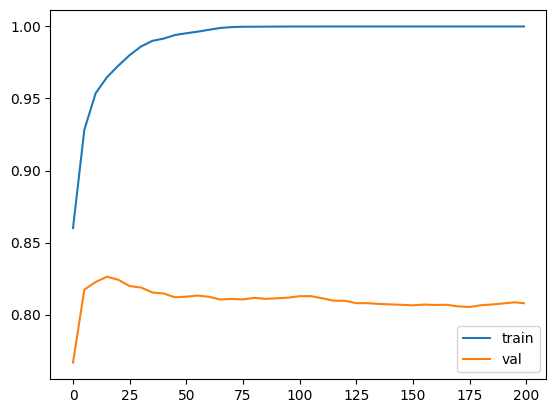

In [72]:
plt.plot(results_df.tree_index, results_df.train_auc, label="train");
plt.plot(results_df.tree_index, results_df.val_auc, label="val");
plt.legend();